## Part 2 - Data Cleaning
During our EDA we encountered some variables with incomplete or corrupted data.  
In this notebook we will use Pandas to:
* Remove outliers  
* Handle missing, null or corrupted values  

In [52]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Preview the data 

In [53]:
df_dirty = pd.read_csv('./data/sf/data.csv')
df_dirty.head(5) # display first 5 entries of DataFrame

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,Condo For Sale,550 Davis St UNIT 44,San Francisco,CA,94111,1995000.0,"3 bds , 2 ba , 1,520 sqft",Sotheby's International Realty,https://www.zillow.com/homedetails/550-Davis-S...,3.0,2.0,1520.0,condo,NaN
1,Condo For Sale,240 Lombard St APT 437,San Francisco,CA,94111,625000.0,"1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,566.0,condo,NaN
2,Condo For Sale,550 Davis St UNIT 39,San Francisco,CA,94111,1196000.0,"1 bd , 1 ba , 914 sqft",NaN,https://www.zillow.com/homedetails/550-Davis-S...,1.0,1.0,914.0,condo,NaN
3,Condo For Sale,77 Dow Pl APT 701,San Francisco,CA,94107,935000.0,"1 bd , 1.5 ba , 1,022 sqft",Vanguard Properties,https://www.zillow.com/homedetails/77-Dow-Pl-A...,1.0,1.5,1022.0,condo,NaN
4,House For Sale,807 Francisco St,San Francisco,CA,94109,16900000.0,"6 bds , 6.5 ba , 6,180 sqft",Compass,https://www.zillow.com/homedetails/807-Francis...,6.0,6.5,6180.0,house,"(37.8038257453414, -122.41844925566)"


## Remove outliers
Recall from our EDA that our price data has outliers which result in high skewness and kurtosis values.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 4.273490547566425
Kurtosis: 24.274132451312706


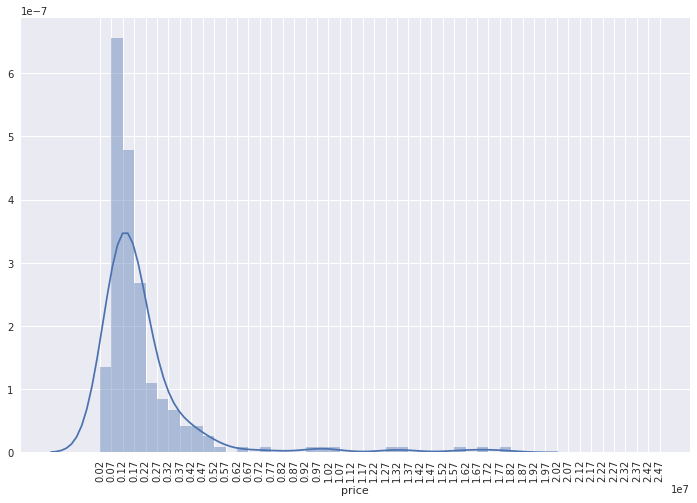

In [54]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(dataframe: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(dataframe.price, bins=bins)

bins = range(int(df_dirty.price.min()),int(df_dirty.price.max()),500000)
bins
plot_prices(df_dirty.dropna(), bins)
print(f'Skewness: {df_dirty.price.skew()}')
print(f'Kurtosis: {df_dirty.price.kurt()}')

In [55]:
cutoff = 8e6
df_clean = df_dirty[df_dirty['price'] <= cutoff]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 2.069487
Kurtosis: 4.503858


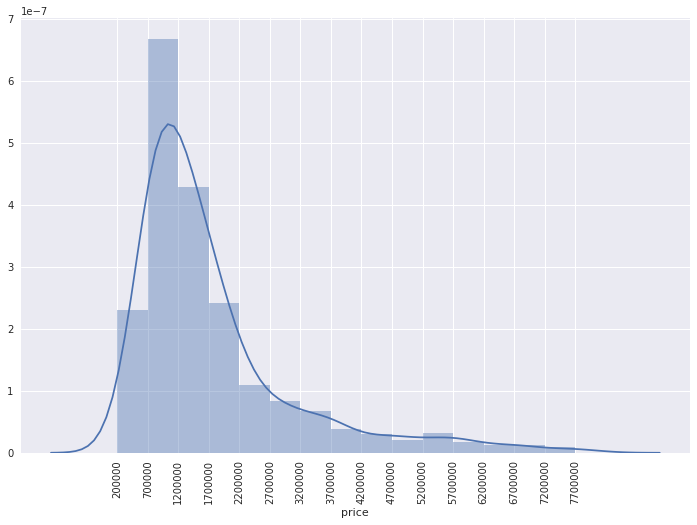

In [56]:
bins = range(int(df_clean.price.min()),int(df_clean.price.max()),500000)
plot_prices(df_clean, bins)
print("Skewness: %f" % df_clean['price'].skew())
print("Kurtosis: %f" % df_clean['price'].kurt())

The skewness and kurtosis values have improved. The distribution is still skewed however there are transformations we can apply to the dataset to make it more normally distributed. More on these transformations in a later notebook.

In [57]:
num_zero_sqft = (df_dirty['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 1 entries with zero sqft


In [58]:
df_clean = df_dirty[df_dirty['sqft'] > 10]
num_zero_sqft = (df_clean['sqft'] < 10).sum()
print("There are {} entries with zero sqft".format(num_zero_sqft))

There are 0 entries with zero sqft


## Deal with Null and Missing values

In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 698
Data columns (total 14 columns):
title                   639 non-null object
address                 639 non-null object
city                    639 non-null object
state                   639 non-null object
postal_code             639 non-null int64
price                   639 non-null float64
facts and features      639 non-null object
real estate provider    496 non-null object
url                     639 non-null object
bed                     627 non-null float64
bath                    532 non-null float64
sqft                    639 non-null float64
property_type           632 non-null object
latlng                  409 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 74.9+ KB


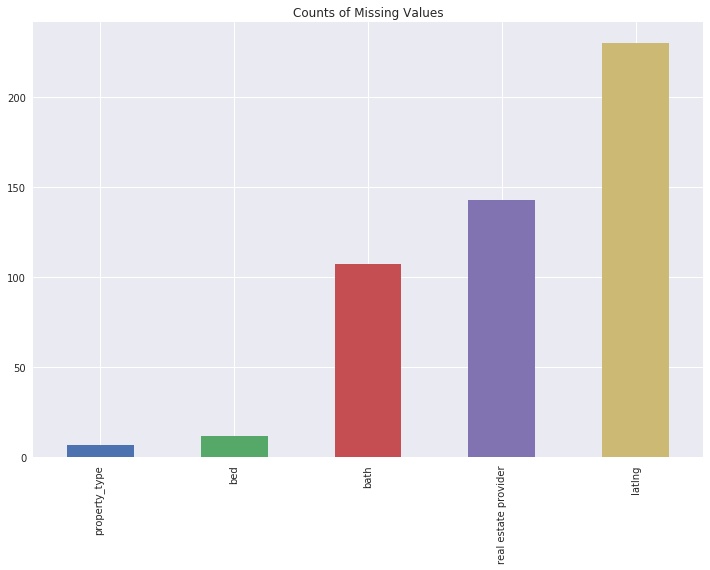

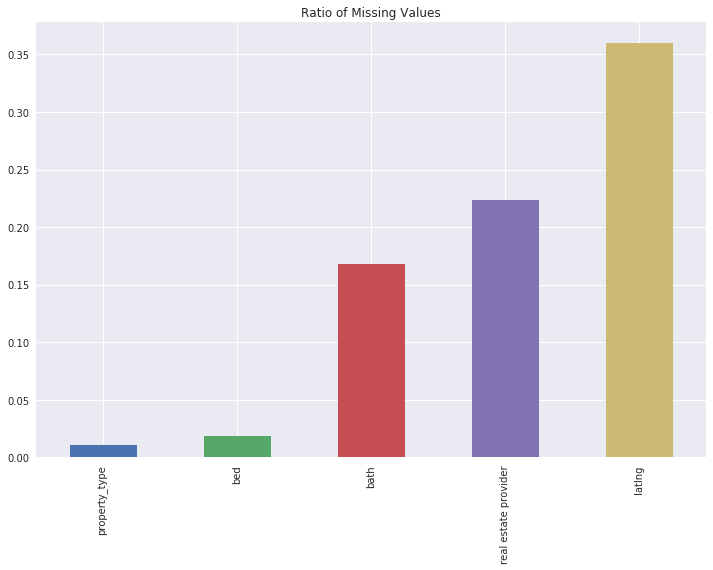

In [60]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.title("Counts of Missing Values")
plt.show()
missing_ratio = missing / len(df_clean)
missing_ratio.plot.bar()
plt.title("Ratio of Missing Values")
plt.show()

First, we will choose to remove the `latlng` column completely. Although there may be some use cases for this data (eg. find distance to nearby schools, parks, etc.) we will remove it and keep the `postal_code` column as our location data.  
We will also remove `real estate provider` since there are too many unique values.

In [61]:
print(df_clean.columns)
df_clean = df_clean.drop(columns=['latlng', 'real estate provider'])
print(df_clean.columns)

Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'real estate provider', 'url', 'bed', 'bath',
       'sqft', 'property_type', 'latlng'],
      dtype='object')
Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'url', 'bed', 'bath', 'sqft', 'property_type'],
      dtype='object')


Now we could choose to drop all rows with null/missing values with `df.dropna()`, but we may benefit from "imputing" these values instead:  

**Imputation** fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely.

In [64]:
df_clean_dropna = df_clean.dropna()

In [79]:
from sklearn.preprocessing import Imputer
df_clean_imputed = df_clean.copy() # copy original for safe keeping
columns_to_impute = ['bed', 'bath', 'sqft'] # only impute numerical columns
imputer = Imputer(strategy='mean')
imputed_columns = imputer.fit_transform(df_clean_imputed[columns_to_impute])
df_clean_imputed[columns_to_impute] = imputed_columns
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 698
Data columns (total 12 columns):
title                 639 non-null object
address               639 non-null object
city                  639 non-null object
state                 639 non-null object
postal_code           639 non-null int64
price                 639 non-null float64
facts and features    639 non-null object
url                   639 non-null object
bed                   639 non-null float64
bath                  639 non-null float64
sqft                  639 non-null float64
property_type         632 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 64.9+ KB


Now that we have imputed all of the values we can, let's drop the rest of the rows containing null values

In [80]:
df_clean_imputed = df_clean_imputed.dropna()

In [81]:
df_clean_imputed = df_clean_imputed[df_clean_imputed.postal_code != 94501] 

In [82]:
df_clean_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 698
Data columns (total 12 columns):
title                 630 non-null object
address               630 non-null object
city                  630 non-null object
state                 630 non-null object
postal_code           630 non-null int64
price                 630 non-null float64
facts and features    630 non-null object
url                   630 non-null object
bed                   630 non-null float64
bath                  630 non-null float64
sqft                  630 non-null float64
property_type         630 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 64.0+ KB


 ## Save the dataframes to .csv

In [83]:
df_clean_dropna.to_csv('./data/sf/data_clean_dropna.csv', index=False)
df_clean_imputed.to_csv('./data/sf/data_clean_imputed.csv', index=False)